# Clasificación de elementos de una zona urbana con EMP

Autores:
- Juan Carlos Matas Rodríguez
- Manuel Barea Gallego 
- Kenny Jesús Flores Huamán

Esto es una pequeña experimentación de la clasificación de elementos de una zona utilizando los perfiles morfológicos extendidos (EMP) y 
una máquina de vectores de soporte para la clasificación de elementos de una zona urbana utilizando el lenguaje de programación Python.

Primero antes que nada, vamos a importar todas las librerías necesarias para este proyecto.

In [1]:
#LIBRERÍAS QUE VAMOS A UTILIZAR

#Numpy para la representación matricial
import numpy as np
# OpenCV Para tratamiento de imágenes
import cv2 as cv
# PyPlot para mostrar como imagen los arrays
from matplotlib import pyplot as plt
# Librería math
import math
# Scipy.io para la lectura de los datos en formato .mat
import scipy.io as io
# Operaciones morfológicas por reconstrucción y creacion de elementos estructurales
import sklearn.preprocessing
from skimage.morphology import reconstruction,erosion,disk,rectangle,diamond,octagon,square
# Librerías para normalizar el dataset (procedimiento estándar)
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing
#Creación de los PCA
from sklearn.decomposition import PCA
from skimage import util
# Librería para dividir el conjunto de datos en conjunto de entrenamiento y de prueba
from sklearn.model_selection import train_test_split
# Librería para crear el clasificador SVM
from sklearn.svm import SVC
# Librería para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
# Librería que imprime la leyenda
import matplotlib.patches as mpatches

Para facilitar el uso de diferentes datasets, se ha creado una clase llamada **EMPClasif** donde contiene todos los métodos necesarios para el proceso de clasificación con perfiles morfológicos extendidos.

## Clase EMPClasif

In [2]:
# Clase que implementa todo el proceso de clasificación con EMPs
class EMPClasif():

    def __init__(self, dataset_route, clasif_route, clases):
        '''
        Constructor de la clase
        Parámetros:
            dataset_route: ruta del archivo .mat que contiene el dataset
            clasif_route: ruta del archivo .mat que contiene la clasificación del dataset
            clases: lista de clases en las que se pretende categorizar cada píxel
        '''
        # Dataset: se guarda como un diccionario cuyas claves son atributos del dataset
        dataset = io.loadmat(dataset_route)

        # Atributo correspondiente al número de bandas, es decir, imágenes tomadas con distintas longitudes de onda
        self.n_bandas = int(dataset['number_of_bands'])
        # Atributo correspondiente al alto de cada imagen
        self.n_filas = int(dataset['number_of_rows'])
        # Atributo correspondiente al ancho de cada imagen
        self.n_columnas = int(dataset['number_of_columns'])
        # Atributo correspondiente a las imágenes en sí, guardadas en un array
        # Cada columna representa una banda, y cada fila los píxeles de la imagen, listados de fila en fila
        self.pixels = np.transpose(dataset['pixels'])
        sc = StandardScaler()
        # Normalización de los píxeles del dataset
        pixels_normalizados = sc.fit_transform(self.pixels)
        # Normalizados a rango (0,1)
        self.pixels_normalizados = sklearn.preprocessing.minmax_scale(
            pixels_normalizados, feature_range=(0, 1))

        # Clasificación del dataset
        clasif_dic = io.loadmat(clasif_route)
        # Array que guarda la clasificación de los píxeles del dataset en 7 tipos de clases
        self.clasif = np.transpose(clasif_dic['pixels']).astype(int)
        # Lista de clases
        self.clases = clases

    def datos(self):
        '''
        Función que muestra en pantalla los atributos de la clase
        '''
        print("ATRIBUTOS DEL DATASET\n------------------------")
        print("n_bandas =", self.n_bandas)
        print("n_filas =", self.n_filas)
        print("n_columnas =", self.n_columnas)
        print("Dimensiones de pixels =", np.shape(self.pixels))
        print("Dimensiones de clasif =", np.shape(self.clasif))
        print("Clases =", self.clases)

    def expan(self, img, cmin, cmax):
        '''
        Función auxiliar que realiza una expansión lineal del histograma
        Parámetros:
            img: la imagen a expandir
            cmin,cmax: límites inferior y superior de valores del histograma a expandir
        Devuelve:
            Imagen con histograma expandido linealmente
        '''
        resimg = img.copy()  # Copiar imagen
        prod = round(255 / (cmax - cmin))
        return (((resimg - cmin) * prod).clip(min=0, max=255)).astype(int)

    def corte(self, img, porc):
        '''
        Función auxiliar que realiza un corte de colas a una imagen (expansión lineal con valores cmin y cmax en función
        de un porcentaje)
        Parámetros:
            img: la imagen a expandir
            porc: porcentaje de píxeles que se desean excluir del histograma a expandir
        '''
        hist, binedges = np.histogram(img, bins=range(
            0, 255))  # Historiograma de la imagen (frecs y NDs respectivamente)
        total = np.sum(hist)  # Total de píxeles
        cut = round(total*porc)  # Nº píxeles a partir del cual se hace corte
        ac = 0  # Valor acumulado

        # Búsqueda de cmin
        for i in binedges[1:-1]:  # Para cada ND (ignorando extremos)
            # Se acumula la frecuencia absoluta del ND con valor i
            ac += hist[i]
            if ac >= cut:  # Si la frecuencia acumulada supera el valor de corte
                cmin = i  # El corte inferior es i
                break  # Se detiene el bucle

        # Búsqueda de cmax
        ac = 0  # Reseteo del valor acumulado
        # Para cada ND, en orden inverso (ignorando extremos)
        for i in np.flip(binedges[1:-1]):
            # Se acumula la frecuencia absoluta del ND con valor i
            ac += hist[i]
            if ac >= cut:  # Si la frecuencia acumulada supera el valor de corte
                cmax = i  # El corte superior es i
                break  # Se detiene el bucle

        return self.expan(img, cmin, cmax)

    def extraeBanda(self, banda, cortar=True):
        '''
        Función auxiliar para extraer una banda concreta del dataset
        Parámetros:
            banda: número de la banda que se desea extraer
            cortar: si es True, se realiza un corte de colas a la imagen resultante
        Devuelve:
            array de la imagen correspondiente a la banda deseada
        '''
        aux = np.copy(self.pixels_normalizados)
        res = (aux[:, banda-1]).reshape((self.n_filas, self.n_columnas))
        if cortar:
            # Corte de colas del 1%
            return self.corte((res*255).astype(np.uint8), 0.01)
        return (res*255).astype(np.uint8)

    def imagenMulticanal(self, bandas, cortar=True):
        '''
        Función auxiliar para crear una imagen RGB a partir de 3 bandas a elección
        Parámetros:
            bandas: tupla de bandas a combinar
            cortar: si es True, se realiza un corte de colas a cada banda
        Devuelve:
            array de la imagen RGB correspondiente
        '''
        r = self.extraeBanda(bandas[0], cortar)
        g = self.extraeBanda(bandas[1], cortar)
        b = self.extraeBanda(bandas[2], cortar)
        return cv.merge((r, g, b))

    def imagenClasif(self,clasif):
        '''
        Función auxiliar para crear una imagen que muestre la clasificación de píxeles dada por una clasificación
        '''
        colores = [
            [255,255,255], # Blanco
            [244,50,46], # Rojo
            [244,245,46], # Amarillo
            [115,77,46], # Marrón
            [51,245,46], # Lima
            [51,108,46], # Verde
            [51,50,238], # Azul
            [148,50,238] # Violeta
        ]
        #         colores = [[255,255,255], [255, 254, 137], [3,  28,  241], [255, 89,    1], [5,   255, 133],
        #                                [255,   2, 251], [89,  1,  255], [3,   171, 255], [12,  255,   7],
        #                                [172, 175,  84], [160, 78, 158], [101, 173, 255], [60,   91, 112],
        #                                [104, 192,  63], [139, 69,  46], [119, 255, 172], [254, 255,   3]]
        mapa = clasif.reshape((self.n_filas,self.n_columnas)) # Imagen con cada pixel clasificado con un nº del 0 al 7
        lista_mapas = []
        
        # Obtención de cada clasificación coloreada
        for c in range(len(self.clases) + 1): # Para cada clase (incluyendo la clase fondo)
            # Array de 3 dimensiones con valor 1 en aquellos píxeles de la clase c y 0 en caso contrario
            mapa_c = (mapa == c).astype(int).reshape((self.n_filas,self.n_columnas,1))
            mapa_c = np.concatenate((mapa_c,mapa_c,mapa_c),axis=2) * colores[c] # Los píxeles de valor 1 se colorean
            lista_mapas.append(mapa_c)
        
        return sum(lista_mapas) # Unión de todas las coloraciones en una sola imagen


    def construccion_pca(self, numero_pca, mostrar=False):
        '''
        Función auxiliar para crear un un array de componentes principales del dataset
        Parámetros:
            data: dataset a utilizar
            numero_pca: numero de componentes principales a crear
            mostrar: determina si se mostrarán los PC por la consola
        Devuelve:
            array de los PC
        '''
        columnas = numero_pca #tendremos tantos elementos en el array como numero de PC deseado
        rows = 1
        fig = plt.figure(figsize=(15, 15))

        pca = PCA(n_components=numero_pca) #se utiliza la funcion de procesado de sklearn
        pc = pca.fit_transform(self.pixels)

        pc_imagenes = np.zeros(shape=(self.n_filas, self.n_columnas, numero_pca))

        for i in range(numero_pca):
            pc_imagenes[:, :, i] = np.reshape(
                pc[:, i], (self.n_filas, self.n_columnas))
            if mostrar:
                fig.add_subplot(rows, columnas, i+1)
                plt.imshow(pc_imagenes[:, :, i], cmap='gray',
                           interpolation='bicubic')

        return pc_imagenes

    def construccion_mp(self, image, es_tamY=2, es_tamX=0, incremento_Tam=2, num_Iteraciones=4, elementoEstructural=disk):
        ''''
        Funcion auxiliar que construye los Morphological Profiles
        Parámetros:
            image: imagen de la que se va a construir el MP
            es_tamY: tamaño y del SE
            es_tamX: tamaño x del SE
            incremento_Tam: como va a ir incrementando el SE
            num_Iteraciones: numero de aperturas y clausuras por reconstrucción que se le va a aplicar
            elementoEstructural: SE que se va a usar
        Devuelve:
            Un perfil morfológico
        '''
        x, y = image.shape #tamaño x,y de la imagen

        cpr = np.zeros(shape=(x, y, num_Iteraciones)) #array vacío con el tamaño de la imagen para introducir valores de clausura
        apr = np.zeros(shape=(x, y, num_Iteraciones)) #array vacío con el tamaño de la imagen para introducir valores de apertura

        it = 0  #numero de iteraciones, crece hasta llegar a num_Iteraciones
        tamY = es_tamY #tamaño vertical del elemento estructural, se usa como el tamaño unico si el elemento no precisa de 2 valores de entrada
        tamX = es_tamX #tamaño horizontal
        while it < num_Iteraciones:
            se = self.crearElementoEstructural(tamY, tamX, elementoEstructural) #creación del elemento estructural con el tamaño y tipo dado
            temp = self.cerrar_por_reconstruction(image, se) #array temporal con los valores de clausura por reconstrucción
            cpr[:, :, it] = temp[:, :]
            temp = self.abrir_por_reconstruccion(image, se) #array temporal con los valores de clausura por reconstrucción
            apr[:, :, it] = temp[:, :]
            tamY += incremento_Tam #aumentamos el tamaño del elemento estructural en cada ciclo
            tamX += incremento_Tam
            it += 1 #aumentamos el contador de iteraciones

        mp = np.zeros(shape=(x, y, (num_Iteraciones*2)+1))
        cont = num_Iteraciones - 1

        for i in range(num_Iteraciones): #crea el perfil morfologico a partir de los valores temporales de clausura por reconstruccion
            mp[:, :, i] = cpr[:, :, cont]
            cont = cont - 1

        mp[:, :, num_Iteraciones] = image[:, :] 

        cont = 0
        for i in range(num_Iteraciones+1, num_Iteraciones*2+1): #crea el perfil morfologico a partir de los valores temporales de apertura por reconstruccion
            mp[:, :, i] = apr[:, :, cont]
            cont += 1

        return mp

    def construccion_emp(self, base_image, es_tamY=4, es_tamX=0, incremento_Tam=2, num_Iteraciones=4, elementoEstructural=disk):
        ''''
        Funcion que construye un Extended Morphological Profile
        Parámetros:
            base_image: Las imágenes de las que va a estar formada el EMP
            es_tamY: tamaño y del SE
            es_tamX: tamaño x del SE
            incremento_Tam: como va a ir incrementando el SE
            num_Iteraciones: numero de aperturas y clausuras por reconstrucción que se le va a aplicar
            elementoEstructural: SE que se va a usar
        Devuelve:
            El EMP creado
        '''
        filas_imagen, columnas_imagen, canales = base_image.shape
        tam_mp = (num_Iteraciones * 2) + 1
        tamp_emp = tam_mp * canales
        emp = np.zeros(shape=(filas_imagen, columnas_imagen, tamp_emp))

        cont = 0
        for i in range(canales):
            # construye MPs
            mp_temp = self.construccion_mp(base_image[:, :, i], es_tamY, es_tamY,
                                    incremento_Tam, num_Iteraciones, elementoEstructural)
            aux = tam_mp * (i+1)

            # construye el EMP
            cont_aux = 0
            for k in range(cont, aux):
                emp[:, :, k] = mp_temp[:, :, cont_aux]
                cont_aux += 1

            cont = tam_mp * (i+1)

        return emp

    def crearElementoEstructural(self, es_tamY=2, es_tamX=0, elementoEstructural=disk):
        
        '''
        Función auxiliar que devuelve un elemento estructural

        Parámetros: 
            es_tamY: Tamaño y del elemento estructural (Se usa este si el SE solo precisa de 1 parámetro)
            es_tamX: Tamaño x del elemento estructural (Se usa solamente para Rectangle y Octagon)
            elementoEstructural: forma del elemento estructural (DIAMOND, RECTANGLE, SQUARE, DISK, STAR, OCTAGON)
        Devuelve:
            El elemento estructural con las dimensiones correspondientes
        '''

        if(elementoEstructural == rectangle or elementoEstructural == octagon):
            return elementoEstructural(es_tamY, es_tamX) #si el elemento estructural es rectángulo u octágono, se crea pasando el tamaño x e y
        else:
            return elementoEstructural(es_tamY) #en cualquier otro caso, el elemento estructural solo precisa de una variable de entrada

    def abrir_por_reconstruccion(self, image, se):
        '''
        Realiza una Apertura por Reconstrucción

        Parámetros:
            image: matriz de 2 dimensiones.
            se: elemento estructural
        Devuelve:
            Una matriz 2D de la imagen reconstruída
        '''
        eroded = erosion(image, se) #procesa la imagen por erosion
        reconstructed = reconstruction(eroded, image) # reconstruye la imagen
        return reconstructed

    def cerrar_por_reconstruction(self, image, se):
        '''
        Realiza una Clausura por Reconstrucción

        Parámetros:
            image: matriz de 2 dimensiones.
            se: elemento estructural
        Devuelve:
            Una matriz 2D de la imagen reconstruída
        '''
        obr = self.abrir_por_reconstruccion(image, se) #procesa la imagen por erosion
        obr_inverted = util.invert(obr) #inverso de la imagen procesada por erosion
        obr_inverted_eroded = erosion(obr_inverted, se)  #erosion de la imagen inversa
        obr_inverted_eroded_rec = reconstruction(obr_inverted_eroded, obr_inverted) #inversion de la imagen inversa erosionada
        obr_inverted_eroded_rec_inverted = util.invert(obr_inverted_eroded_rec)
        return obr_inverted_eroded_rec_inverted

    def clasificador(self,datos):
        '''
        Función para crear un clasificador SVM, entrenarlo y testearlo.
        Parámetros:
            datos: imágenes que se usarán para entrenar y testear el clasificador (en forma de array de 3 dimensiones)
        Devuelve:
            Clasificador entrenado
            Clasificación predicha por el clasificador
            Clasificación real de los píxeles cuya clase se ha tratado de predecir
        '''
        datosC = np.copy(datos)
        h,w,z = np.shape(datosC)
        # Los píxeles de cada imagen de los datos se reordenan para que la imagen sea 1 pixel de ancho y se concatenan
        # una detrás de la otra, resultando en un conjunto de datos de la misma forma que el dataset, es decir, un array
        # donde cada columna representa cada imagen (en el dataset esto de corresponde con el número de banda), y en filas
        # están los píxeles correspondientes
        x = np.concatenate(tuple(datosC[:,:,i].reshape((h*w,1)) for i in range(z)),axis=1)
        y = self.clasif.ravel() # Se pasa a array de 1 dimensión
        no_ceros = y != 0 # Píxeles con valor de clasificación distinto a 0, es decir, distinto a fondo (sin clasificar)
        # Eliminación de píxeles sin clasificación
        x = x[no_ceros]
        y = y[no_ceros]
        
        # División de datos en conjunto de entrenamiento y de testeo ()
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
        # Creación del clasificador SVM
        clasifSVM = SVC(kernel='rbf', random_state=0)
        # Entrenamiento del clasificador
        clasifSVM.fit(x_train, y_train)
        # Testeo del clasificador
        y_pred = clasifSVM.predict(x_test)
        return clasifSVM, y_pred, y_test
    
    def prediccionVSReal(self,pred,real,titulo="Matriz de confusión"):
        '''
        Función para mostrar en pantalla una comparación de los resultados predichos por un clasificador vs los valores
        reales, por medio de una matriz de confusión.
        Parámetros:
            pred: clasificación predicha
            real: clasificación real
            titulo: título de la representación gráfica en pantalla
        '''
        cm = confusion_matrix(real,pred)
        
        fmt = '.2f' # Formato de texto. Servirá para mostrar solo las 2 primeras cifras decimales de los valores
        
        diag = cm.diagonal() # Píxeles clasificados correctamente para cada clase
        efectividad = 100 * np.sum(diag) / np.sum(cm) # Porcentaje de píxeles clasificados correctamente respecto al total
        # Porcentajes de píxeles clasificados correctamente como una cierta clase respecto a todos los píxeles que debían
        # ser clasificados realmente como esa clase (lo que se conoce como fiabilidad del productor)
        fiab_prod = diag / np.sum(cm,axis=1).clip(min=1)
        # Porcentajes de píxeles clasificados correctamente como una cierta clase respecto a todos los píxeles que se han
        # clasificado como esa clase (lo que se conoce como fiabilidad del usuario)
        fiab_user = diag / np.sum(cm,axis=0).clip(min=1)
        # Clase con menor fiabilidad del productor
        clase_min_fiab_prod = self.clases[np.where(fiab_prod == np.min(fiab_prod))[0][0]]
        # Clase con menor fiabilidad del usuario
        clase_min_fiab_user = self.clases[np.where(fiab_user == np.min(fiab_user))[0][0]]
        print("Porcentaje de acierto: " + bold(format(efectividad,fmt) + "%"))
        print("Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: "
             + bold(clase_min_fiab_prod))
        print("Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: "
             + bold(clase_min_fiab_user))
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalización de los datos de la matriz de confusión
        
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(titulo)
        plt.colorbar() # Barra de colores. Nos muestra que cuanto más alto sea un valor, su color será más azul
        
        # Etiquetas de las barras horizontal y vertical
        tick_marks = np.arange(len(self.clases))
        plt.xticks(tick_marks, self.clases, rotation=45)
        plt.yticks(tick_marks, self.clases)

        umbral = 0.5
        # Para cada posición i,j de la matriz de confusión
        for i in range(cm.shape[0]): 
            for j in range(cm.shape[1]):
                # A cada valor de la matriz se le asocia el formato que se comentó anteriormente sobre mostrar solo las 2
                # primeras cifras decimales, se centra, y finalmente se colorea el texto de blanco si su valor es superior
                # a 0.5 (implicando que su color de fondo será más azul), y de negro en caso contrario
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > umbral else "black")

        plt.tight_layout() # Se ajustan los elementos a las dimensiones de la representación gráfica
        plt.ylabel('Clases Reales')
        plt.xlabel('Clases Predichas')
        
    def imagenClasifPrediccion(self,img,clasificador):
        '''
        Función para realizar una clasificación de una imagen multiespectral
        Parámetros:
            img: imagen que se usó para crear el clasificador (EMP)
            clasificador: la SVM que se usará para la clasificación
        Devuelve:
            array con la clasificación de los píxeles
        '''
        imgC = np.copy(img)
        h,w,z = np.shape(imgC)
        # Se aplica el mismo cambio de forma a los datos que en la función clasificador
        x = np.concatenate(tuple(imgC[:,:,i].reshape((h*w,1)) for i in range(z)),axis=1)
        return self.imagenClasif(clasificador.predict(x))

    def mostrarLeyenda(self):
        '''
        Función para mostrar la leyenda de los elementos a clasificar con sus respectivos colores
        '''
        colores2 = np.array([
            [244,50,46],[244,245,46],[115,77,46],[51,245,46],
            [51,108,46],[51,50,238],[148,50,238]]).astype(int)
        colores2 = sklearn.preprocessing.minmax_scale(colores2, feature_range=(0, 1))
        patches = [mpatches.Patch(color=colores2[i], label=self.clases[i]) for i in range(0,len(colores2))]
        plt.legend(handles=patches, loc=4, borderaxespad=0.)
    
    # deficiones

# fin clase


In [3]:
# Clase para cambiar el formato de texto
class textColor:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def bold(text):
    return textColor.BOLD + text + textColor.END

# Prueba con el National Mall (Washington, DC)

### 1. Lectura de las imágenes hiperespectrales

Como imágenes de entrada hemos utilizado un conjunto de imágenes hiperespectrales del Washington DC Mall, que están disponibles a través del sitio web de [MultiSpect](https://engineering.purdue.edu/~biehl/MultiSpec/index.html) perteneciente al centro de investigación de la universidad de Purdue.

In [4]:
#lista que contiene las clases en las que se pretende categorizar cada píxel.
clases_dc = ["Tejados", "Calle", "Camino de grava", "Hierba", "Árboles", "Agua", "Sombra"]

In [5]:
# Importamos el dataset, el conjunto de pruebas y la lista con la que vamos a categorizar los píxeles 
creacionEMPWMall = EMPClasif("images/dc_new.mat","images/dataset_clasif.mat",clases_dc)

In [6]:
#Atributos de nuestro dataset
creacionEMPWMall.datos()

ATRIBUTOS DEL DATASET
------------------------
n_bandas = 191
n_filas = 1280
n_columnas = 307
Dimensiones de pixels = (392960, 191)
Dimensiones de clasif = (392960, 1)
Clases = ['Tejados', 'Calle', 'Camino de grava', 'Hierba', 'Árboles', 'Agua', 'Sombra']


In [7]:
imgrgb = creacionEMPWMall.imagenMulticanal((60,27,17)) # 60(r), 27(g), 17(b)

In [8]:
clasificador = creacionEMPWMall.imagenClasif(creacionEMPWMall.clasif)

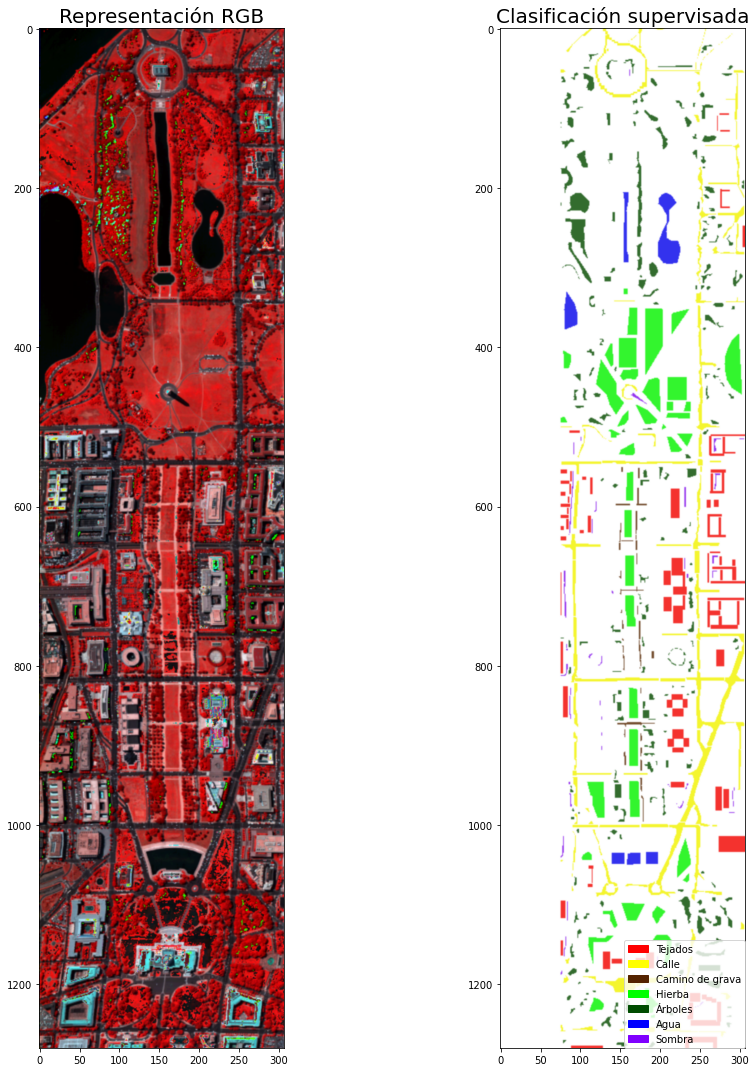

In [9]:
plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.imshow(imgrgb,interpolation='bicubic')
plt.title("Representación RGB", fontsize=20)

plt.subplot(1, 2, 2)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)


creacionEMPWMall.mostrarLeyenda()

plt.tight_layout()
plt.show()

### 2. Creación de los Elementos Estructurales

La creación de los elementos estructurales nos va a servir a la hora de crear los perfiles morfológicos (MP). En este notebook, vamos a aplicar a nuestro dataset 4 diferentes tipos de elementos estructurales, todos provistos por la librería skimage.

Para la creación de estos elementos estructurales, nuestra clase **EMPClasif** cuenta con un método que nos devuelve el elemento estructural que nosotros necesitemos (ya sea un disco,rectángulo, un diamante , un octógono o un cuadrado).


 <img src="images/imagencode1.png" alt="Codigo Elem estructural" style="width:900px;height:400px;"> 

In [10]:
# las imagenes van a ser los SE utilizados
disco = creacionEMPWMall.crearElementoEstructural(es_tamY=4, es_tamX=0, elementoEstructural=disk)
octagono = creacionEMPWMall.crearElementoEstructural(es_tamY=6, es_tamX=3, elementoEstructural=octagon)
rvert =creacionEMPWMall.crearElementoEstructural(es_tamY=7, es_tamX=3, elementoEstructural=rectangle)
rhorizontal =  creacionEMPWMall.crearElementoEstructural(es_tamY=4, es_tamX=8, elementoEstructural=rectangle)

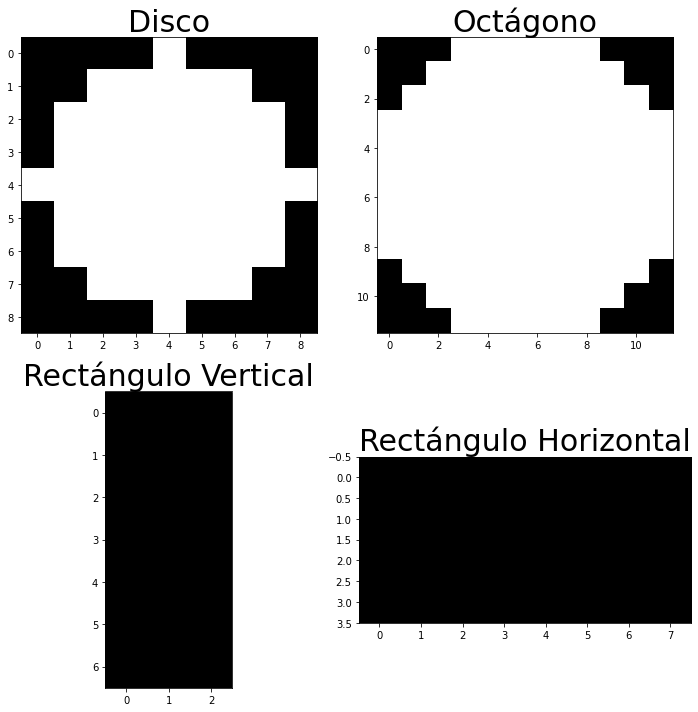

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(disco, cmap="gray")
plt.title("Disco", fontsize = 30)

plt.subplot(2, 2, 2)
plt.imshow(octagono, cmap="gray")
plt.title("Octágono", fontsize = 30)

plt.subplot(2, 2, 3)
plt.imshow(rvert, cmap="gray")
plt.title("Rectángulo Vertical", fontsize = 30)

plt.subplot(2, 2, 4)
plt.imshow(rhorizontal, cmap="gray")
plt.title("Rectángulo Horizontal", fontsize = 30)

plt.tight_layout()
plt.show()

Nota: El rectángulo vertical horirontal y vertical en realidad están pintados todo de blanco, pero como al mostrarlo se vería todo de blanco y no se vería nada, se muestra como negro. Para comprobarlo puede imprimir las siguientes funciones comentadas y ver como en realidad son imágenes donde todos sus píxeles son blanco.

In [21]:
#print("Rectángulo Vertical \n",rvert,"\n")
#print("Rectángulo Horizontal \n ",rhorizontal)

### 3. Análisis de componentes principales (PCA)

No vamos a construir un perfil morfológico para cada una de las 191 bandas del conjunto de datos, de lo contrario, habría que trabajar con una gran cantidad de píxeles. Por ello, hemos decidido aplicar el análisis de componentes principales para reducir el número de bandas, perdiendo la menor cantidad de información posible.


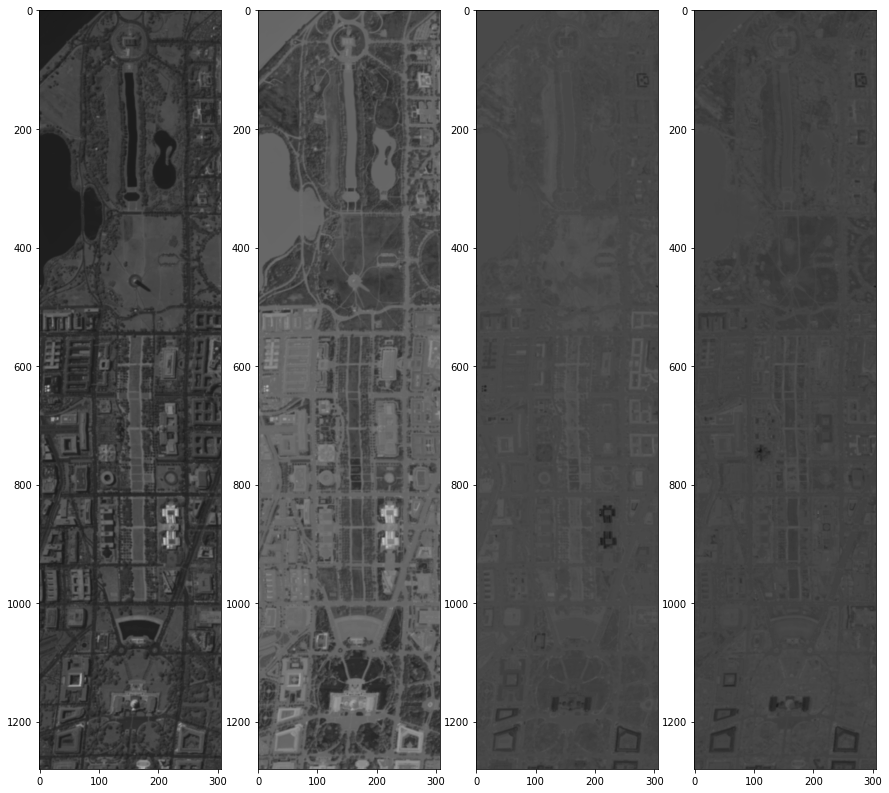

In [15]:
pca_wmall = creacionEMPWMall.construccion_pca(4, True)

### 4. Creación de los perfiles morfológicos (MP) 

El concepto de un perfil morfológico está basado en el uso de operaciones de apertura y clausura por reconstrucción.

Para la creación de los perfiles morfológicos (MP), nuestra clase **EMPClasif** contiene un método llamado **construccion_mp**.

 <img src="images/imagencode2.png" alt="Codigo Elem estructural" style="width:900px;height:400px;"> 

#### Ejemplo para la creación de un perfil morfológico (MP)

Como la creación de los perfiles morfológicos está muy ligada al apartado siguiente, vamos a poner un ejemplo de perfil morfológico usando una de las bandas extraídas directamente de nuestras componentes principales (PCA).

Dimensiones de la imagen b1: (1280, 307)


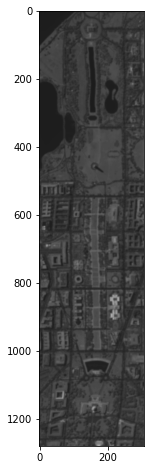

In [16]:
# Ejemplo utilizando la primera banda de nuestro PCA
b1 = pca_wmall[:,:,0]
print("Dimensiones de la imagen b1:",b1.shape)
plt.figure(figsize=(8,8))
plt.imshow(b1, cmap='gray', interpolation='bicubic')
plt.show()

In [17]:
# Creamos el perfil morfológico a partir de la primera banda del componente principal (PCA)
b2 = creacionEMPWMall.construccion_mp(b1, es_tamY=4, es_tamX=2, incremento_Tam=2, num_Iteraciones=2, elementoEstructural=disk)

Dimensiones de la imagen b2: (1280, 307, 5)


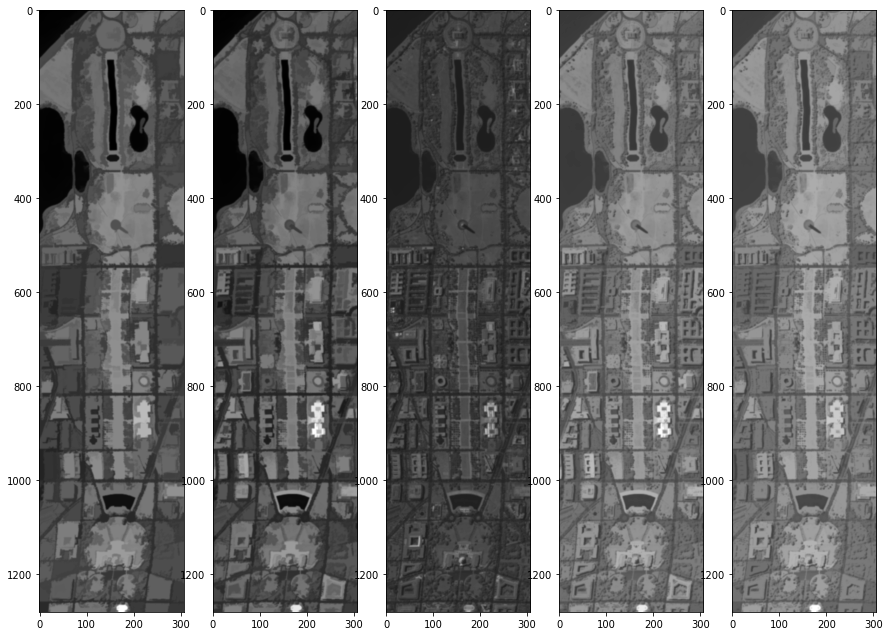

In [18]:
# Vamos a mostrar las diferentes bandas de las que se forma el perfil morfológico creado anteriormente
rows, colums, bands = b2.shape #dimensiones imagen
print("Dimensiones de la imagen b2:",b2.shape)
f, axes = plt.subplots(nrows=1, ncols=bands, figsize=(15,15))
axes = np.array(axes).flatten()
index = 0
for i in range(bands):
    axes[index].imshow(b2[:, :, index], cmap='gray', interpolation='bicubic') # Mostramos cada banda de la imagen
    index +=1

plt.show()

### 5. Creación de los perfiles morfológicos extendidos (EMP) 

Los perfiles morfológicos extendidos (EMP) se basan en la concatenación de varios perfiles morfológicos.

Cada perfil morfológico (MP) aplía o reduce estructuras oscuras y brillantes mediante aperturas y cierres por reconstrucción, dando como resultado una versión más homogénea de la imagen original. En cada iteración, el elemento estructural (SE) se incrementa para captural más información espacial.

En nuestro proyecto, hemos optado por crear 4 perfiles morfológicos extendidos utilizando diferentes elementos estructurales.

### Creación de EMP utilizando el elemento estructural Disco

In [19]:
#VARIABLES A EDITAR PARA EXPERIMENTAR

structuralElem = disk #FORMA ELEM ESTRUCTURAL (DIAMOND, RECTANGLE, SQUARE, DISK, STAR, OCTAGON)
structuralYSize = 4 #TAMAÑO Y ELEMENTO ESTRUCTURAL. SE USA ESTE SI EL STRUCTURAL ELEMENT SOLO PRECISA DE 1 PARAMETRO
structuralXSize = 0 #TAMAÑO X ELEMENTO ESTRUCTURAL. SE USA PARA RECTANGLE Y OCTAGON
structuralSizeIncrement = 2 #INCREMENTO DEL ELEMENTO ESTRUCTURAL EN CADA CICLO MP
number_of_pc = pca_wmall.shape[2] # PCA
num_open_close = 4 # num open close
mp_size = (num_open_close * 2) + 1
emp_image = creacionEMPWMall.construccion_emp(base_image=pca_wmall, es_tamY = structuralYSize,
                                              es_tamX = structuralXSize, incremento_Tam = structuralSizeIncrement,
                                              num_Iteraciones=num_open_close, elementoEstructural = structuralElem)

Con 4 componentes principales, 4 aperturas/cierres con un paso creciente de 2, tendremos 36 elementos en el EMP. Inspeccionemos el EMP visualizando sus características en blanco y negro:

EMP:  (1280, 307, 36)


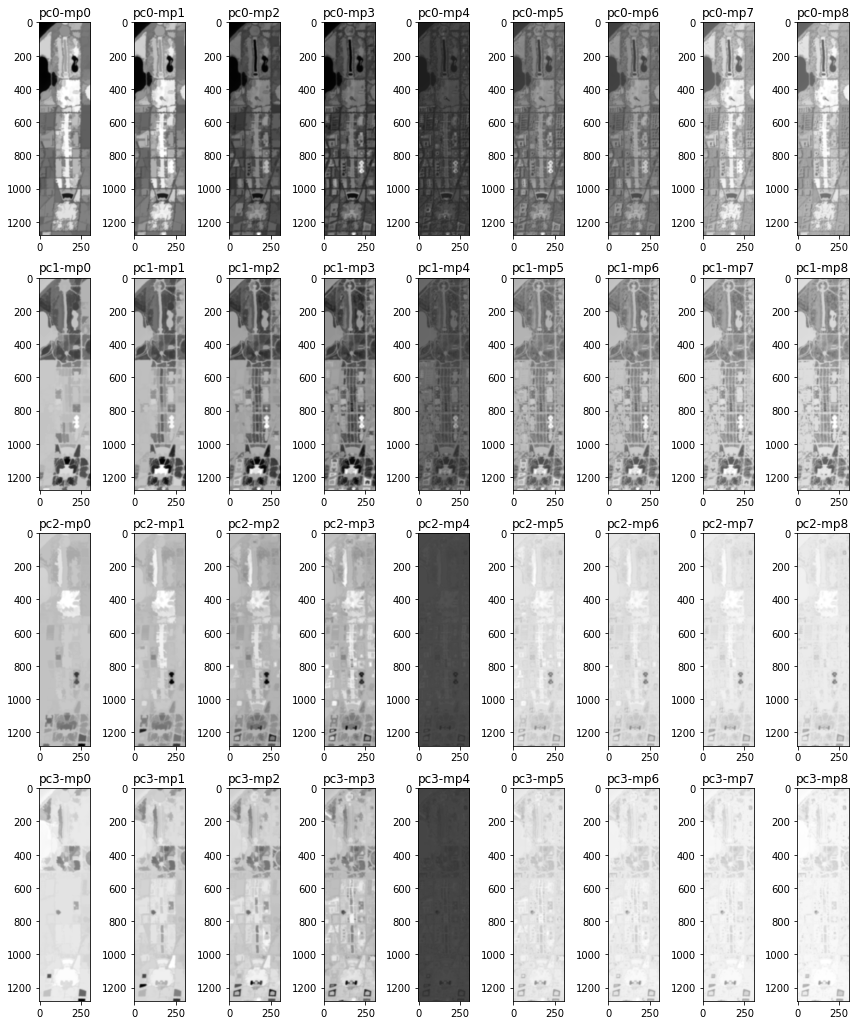

In [20]:
f, axes = plt.subplots(nrows=number_of_pc, ncols= mp_size, figsize=(15,18))
axes = np.array(axes).flatten()
plt.title('EMP se = disco')
print("EMP:  "+str(emp_image.shape))
index = 0
for i in range(0, number_of_pc):
    for x in range(0, mp_size):
        axes[index].set_title('pc' + str(i) + '-mp'+str(x))
        axes[index].imshow(emp_image[:, :, index], cmap='gray', interpolation='bicubic')
        index +=1

plt.show()

### Creación de EMP utilizando el elemento estructural Octágono

In [21]:
#VARIABLES A EDITAR PARA EXPERIMENTAR

structuralElem2 = octagon #FORMA ELEM ESTRUCTURAL (DIAMOND, RECTANGLE, SQUARE, DISK, STAR, OCTAGON)
structuralYSize2 = 6 #TAMAÑO Y ELEMENTO ESTRUCTURAL. SE USA ESTE SI EL STRUCTURAL ELEMENT SOLO PRECISA DE 1 PARAMETRO
structuralXSize2 = 3 #TAMAÑO X ELEMENTO ESTRUCTURAL. SE USA PARA RECTANGLE Y OCTAGON
structuralSizeIncrement2 = 1 #INCREMENTO DEL ELEMENTO ESTRUCTURAL EN CADA CICLO MP
number_of_pc2 = pca_wmall.shape[2] # PCA
num_open_close2 = 4 # num open close
mp_size2 = (num_open_close2 * 2) + 1
emp_image2 = creacionEMPWMall.construccion_emp(base_image=pca_wmall, es_tamY = structuralYSize2,
                                               es_tamX = structuralXSize2, incremento_Tam = structuralSizeIncrement2, 
                                               num_Iteraciones=num_open_close2, elementoEstructural = structuralElem2)

EMP:  (1280, 307, 36)


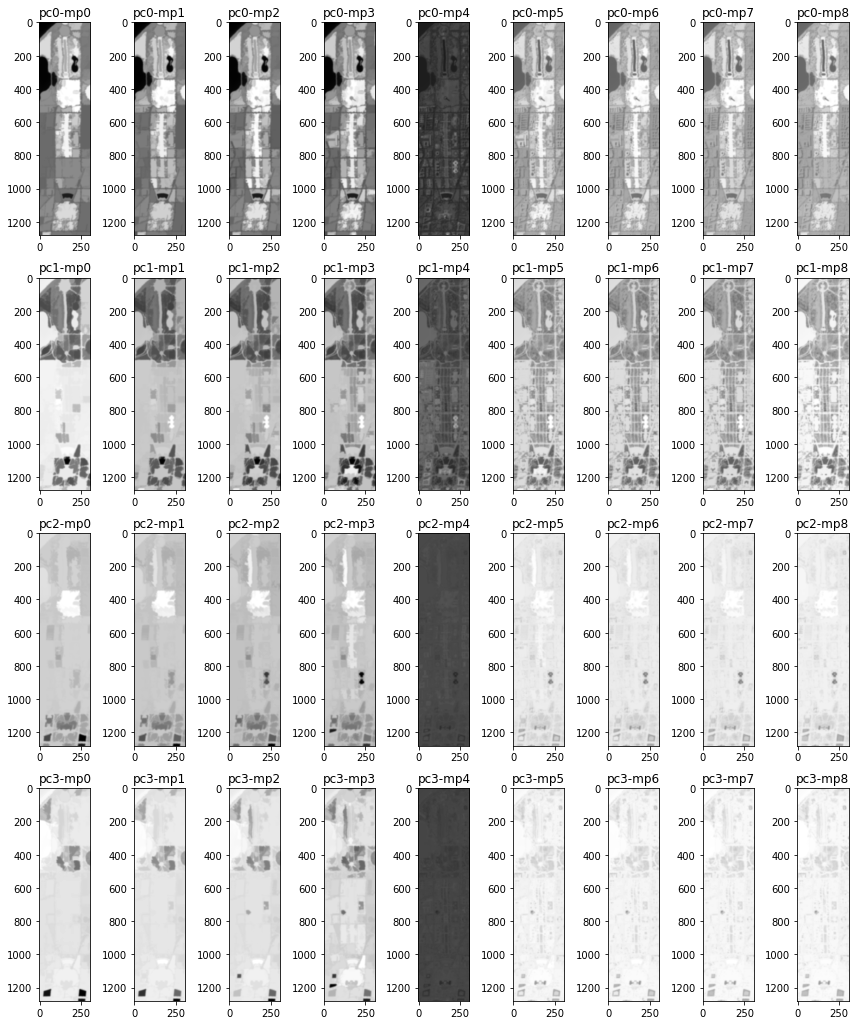

In [22]:
f, axes = plt.subplots(nrows=number_of_pc2, ncols= mp_size2, figsize=(15,18))
axes = np.array(axes).flatten()
plt.title('EMP se = octágono')
print("EMP:  "+str(emp_image2.shape))
index = 0
for i in range(0, number_of_pc2):
    for x in range(0, mp_size2):
        axes[index].set_title('pc' + str(i) + '-mp'+str(x))
        axes[index].imshow(emp_image2[:, :, index], cmap='gray', interpolation='bicubic')
        index +=1

plt.show()

### Creación de EMP utilizando el elemento estructural Rectángulo vertical

In [23]:
#VARIABLES A EDITAR PARA EXPERIMENTAR

structuralElem3 = rectangle #FORMA ELEM ESTRUCTURAL (DIAMOND, RECTANGLE, SQUARE, DISK, STAR, OCTAGON)
structuralYSize3 = 7  #TAMAÑO Y ELEMENTO ESTRUCTURAL. SE USA ESTE SI EL STRUCTURAL ELEMENT SOLO PRECISA DE 1 PARAMETRO
structuralXSize3 = 3 #TAMAÑO X ELEMENTO ESTRUCTURAL. SE USA PARA RECTANGLE Y OCTAGON
structuralSizeIncrement3 = 1 #INCREMENTO DEL ELEMENTO ESTRUCTURAL EN CADA CICLO MP
number_of_pc3 = pca_wmall.shape[2] # PCA


num_open_close3 = 4 # num open close
mp_size3 = (num_open_close3 * 2) + 1
emp_image3 = creacionEMPWMall.construccion_emp(base_image=pca_wmall, es_tamY = structuralYSize3,
                                               es_tamX = structuralXSize3, incremento_Tam = structuralSizeIncrement3,
                                               num_Iteraciones=num_open_close3, elementoEstructural = structuralElem3)

EMP:  (1280, 307, 36)


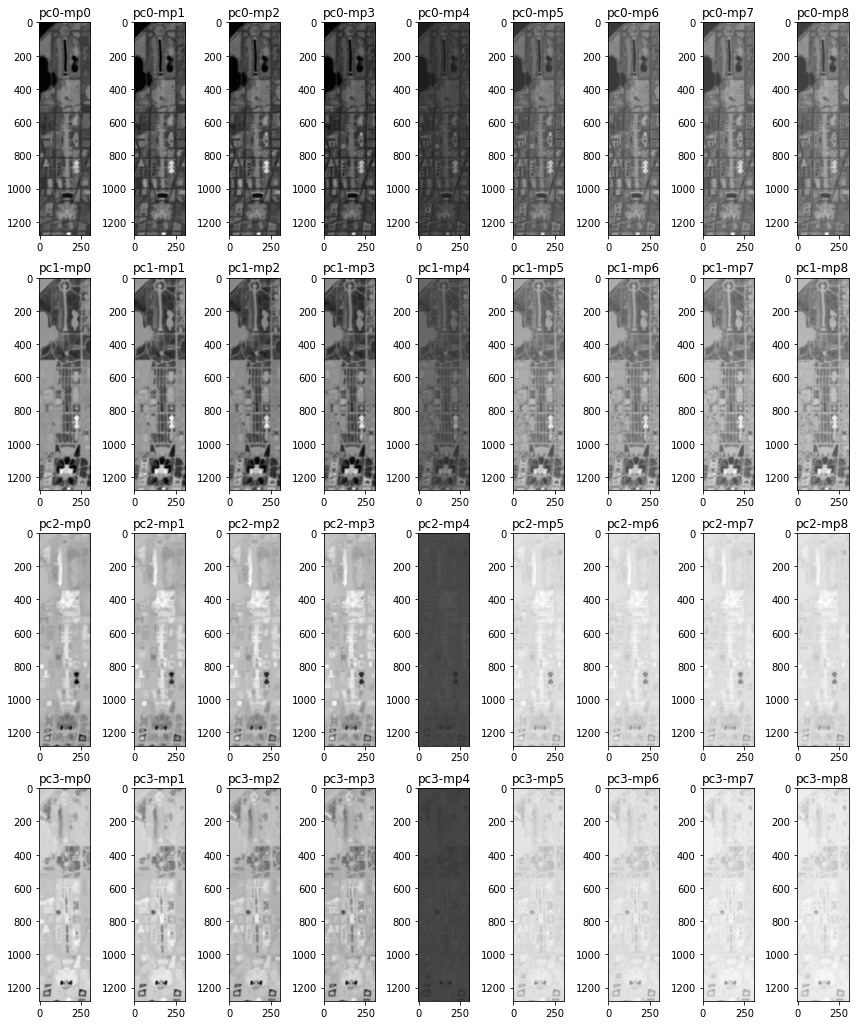

In [24]:
f, axes = plt.subplots(nrows=number_of_pc3, ncols= mp_size3, figsize=(15,18))
axes = np.array(axes).flatten()
plt.title('EMP se = rectángulo vertical')
print("EMP:  "+str(emp_image3.shape))
index = 0
for i in range(0, number_of_pc3):
    for x in range(0, mp_size3):
        axes[index].set_title('pc' + str(i) + '-mp'+str(x))
        axes[index].imshow(emp_image3[:, :, index], cmap='gray', interpolation='bicubic')
        index +=1

plt.show()

### Creación de EMP utilizando el elemento estructural Rectángulo horizontal

In [25]:
#VARIABLES A EDITAR PARA EXPERIMENTAR

structuralElem4 = rectangle #FORMA ELEM ESTRUCTURAL (DIAMOND, RECTANGLE, SQUARE, DISK, STAR, OCTAGON)
structuralYSize4 = 4  #TAMAÑO Y ELEMENTO ESTRUCTURAL. SE USA ESTE SI EL STRUCTURAL ELEMENT SOLO PRECISA DE 1 PARAMETRO
structuralXSize4 = 8 #TAMAÑO X ELEMENTO ESTRUCTURAL. SE USA PARA RECTANGLE Y OCTAGON
structuralSizeIncrement4 = 1 #INCREMENTO DEL ELEMENTO ESTRUCTURAL EN CADA CICLO MP
number_of_pc4 = pca_wmall.shape[2] # PCA
num_open_close4 = 4 # num open close
mp_size4 = (num_open_close4 * 2) + 1
emp_image4 = creacionEMPWMall.construccion_emp(base_image=pca_wmall, es_tamY = structuralYSize4,
                                               es_tamX = structuralXSize4, incremento_Tam = structuralSizeIncrement4,
                                               num_Iteraciones=num_open_close4, elementoEstructural = structuralElem4)

EMP:  (1280, 307, 36)


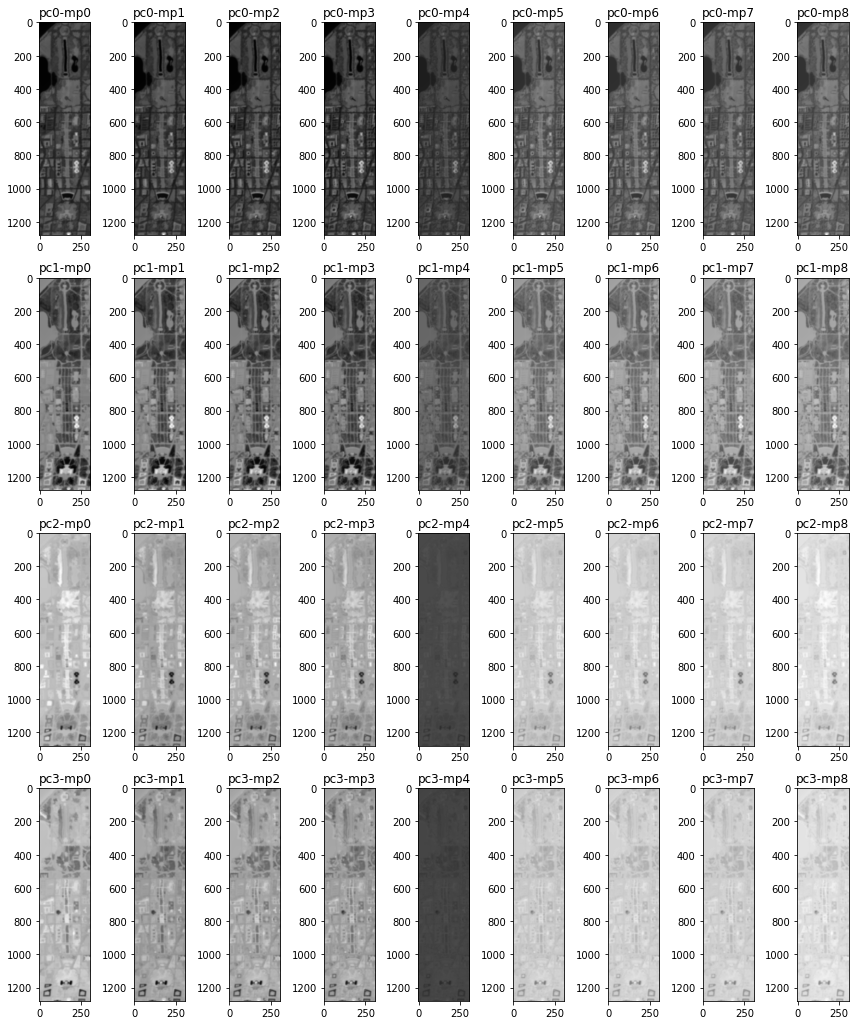

In [26]:
f, axes = plt.subplots(nrows=number_of_pc4, ncols= mp_size4, figsize=(15,18))
axes = np.array(axes).flatten()
plt.title('EMP se = rectángulo horizontal')
print("EMP:  "+str(emp_image4.shape))
index = 0
for i in range(0, number_of_pc4):
    for x in range(0, mp_size4):
        axes[index].set_title('pc' + str(i) + '-mp'+str(x))
        axes[index].imshow(emp_image4[:, :, index], cmap='gray', interpolation='bicubic')
        index +=1

plt.show()

### 6. Creación de un SVM y puesta a prueba


Ahora que hemos creado nuestro conjunto de características con el enfoque EMP, tenemos que construir un modelo de clasificación para asignar cada píxel de nuestra imagen EMP en algunas de nuestras 7 categorías conocidas. Para ello usaremos el algoritmo de aprendizaje Support Vector Machine.

En nuestro caso, vamos a crear un SVM para EMP que hemos creado anteriormente en el paso anterior como también vamos a crear un modelo utilizando nuestra base de datos sin usar el enfoque EMP.

### Creación de SVM utilizando el elemento estructural Disco

In [27]:
clasifSVM, ypred, ytest = creacionEMPWMall.clasificador(emp_image)
#Clasificador entrenado, Clasificación predicha por el clasificador, Clasificación real de los píxeles cuya clase se ha tratado de predecir


### Creación de SVM utilizando el elemento estructural Octágono

In [28]:
clasifSVM2, ypred2, ytest2 = creacionEMPWMall.clasificador(emp_image2) 
#Clasificador entrenado, Clasificación predicha por el clasificador, Clasificación real de los píxeles cuya clase se ha tratado de predecir


### Creación de SVM utilizando el elemento estructural Rectángulo Vertical

In [29]:
clasifSVM3, ypred3, ytest3 = creacionEMPWMall.clasificador(emp_image3)
#Clasificador entrenado, Clasificación predicha por el clasificador, Clasificación real de los píxeles cuya clase se ha tratado de predecir


### Creación de SVM utilizando el elemento estructural Rectángulo Horizontal

In [30]:
clasifSVM4, ypred4, ytest4 = creacionEMPWMall.clasificador(emp_image4)
#Clasificador entrenado, Clasificación predicha por el clasificador, Clasificación real de los píxeles cuya clase se ha tratado de predecir


### Creación de SVM utilizando el dataset sin aplicar un EMP

In [31]:
clasifSVM5, ypred5, ytest5 = creacionEMPWMall.clasificador(pca_wmall)
#Clasificador entrenado, Clasificación predicha por el clasificador, Clasificación real de los píxeles cuya clase se ha tratado de predecir

### 7. Comparación de resultados (matriz de confusión)

Una vez creado nuestro modelo SVM para cada prueba, para verificar los resultados para cada categoría, trazaremos una matriz de confusión para cada SVM creado en eel paso anterior.

### Matriz de confusión utilizando el elemento estructural Disco

Porcentaje de acierto: 99.20%
Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: Sombra
Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: Sombra


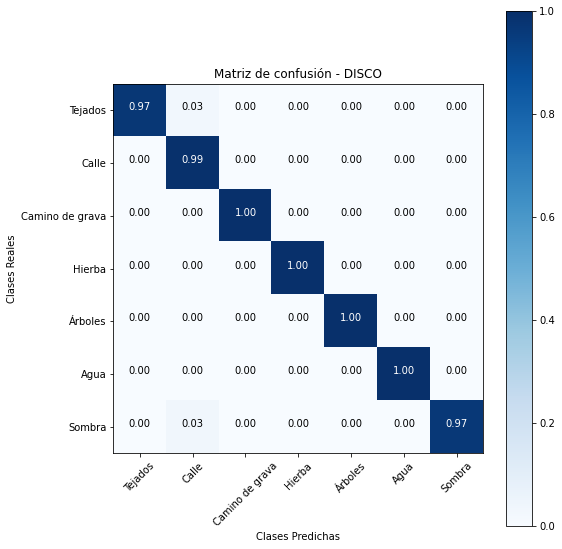

In [32]:
plt.figure(figsize=(8, 8))
creacionEMPWMall.prediccionVSReal(ypred,ytest,"Matriz de confusión - DISCO")
plt.show()

In [33]:
predict1 = creacionEMPWMall.imagenClasifPrediccion(emp_image,clasifSVM)

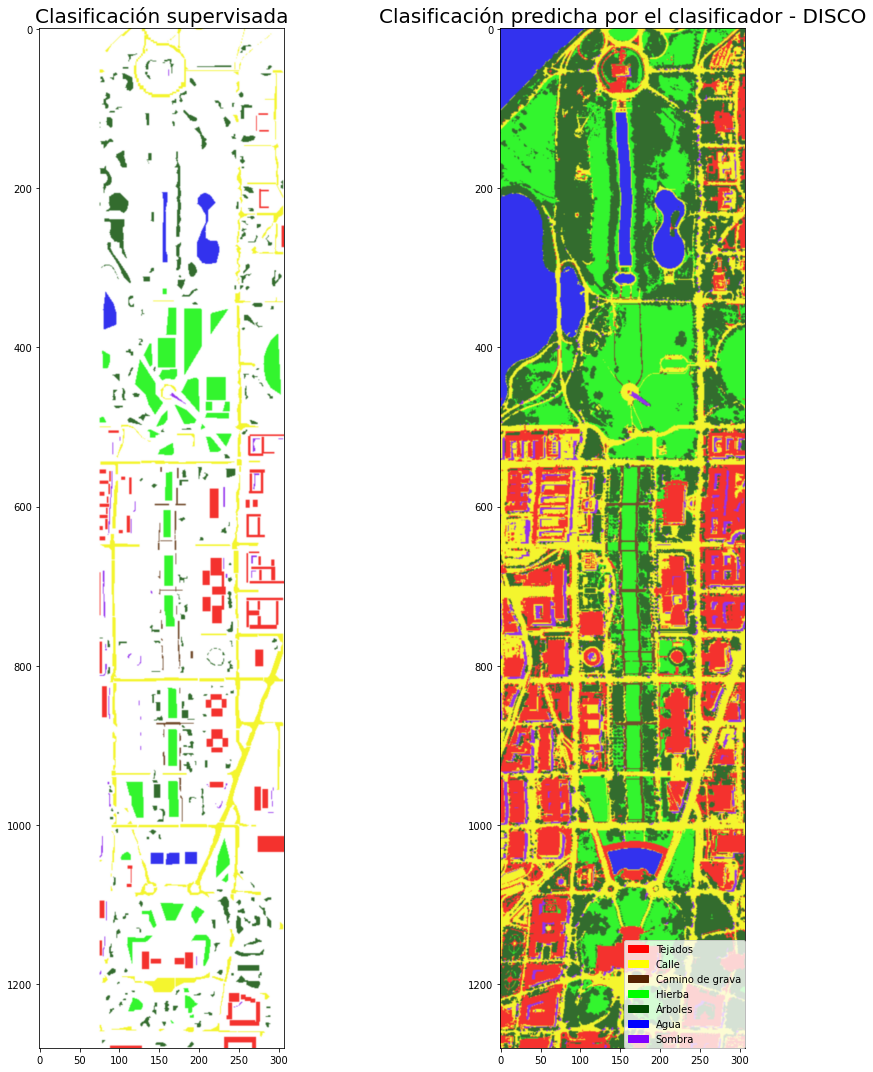

In [34]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(predict1,interpolation='bicubic')
plt.title("Clasificación predicha por el clasificador - DISCO", fontsize = 20)

creacionEMPWMall.mostrarLeyenda()

plt.tight_layout()
plt.show()

### Matriz de confusión utilizando el elemento estructural Octágono

Porcentaje de acierto: 98.41%
Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: Tejados
Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: Sombra


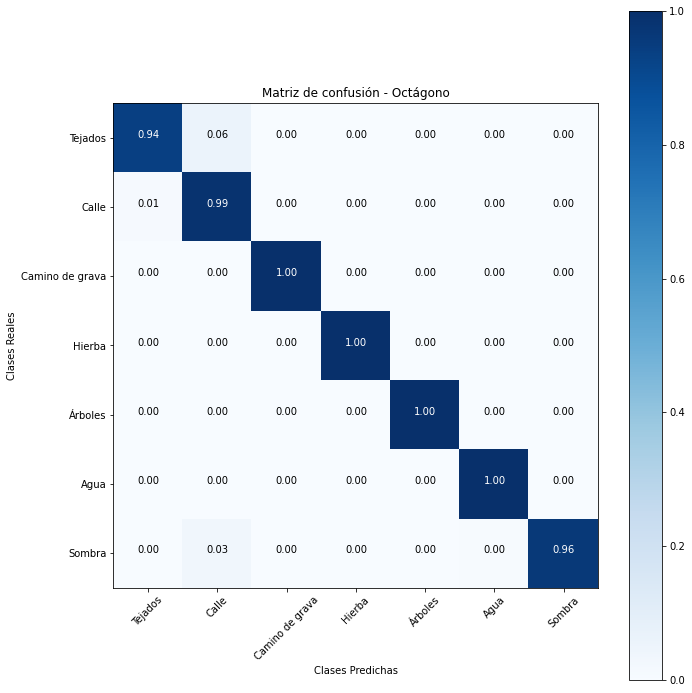

In [35]:
plt.figure(figsize=(10, 10))
creacionEMPWMall.prediccionVSReal(ypred2,ytest2,"Matriz de confusión - Octágono")
plt.show()

In [36]:
predict2 = creacionEMPWMall.imagenClasifPrediccion(emp_image2,clasifSVM2)

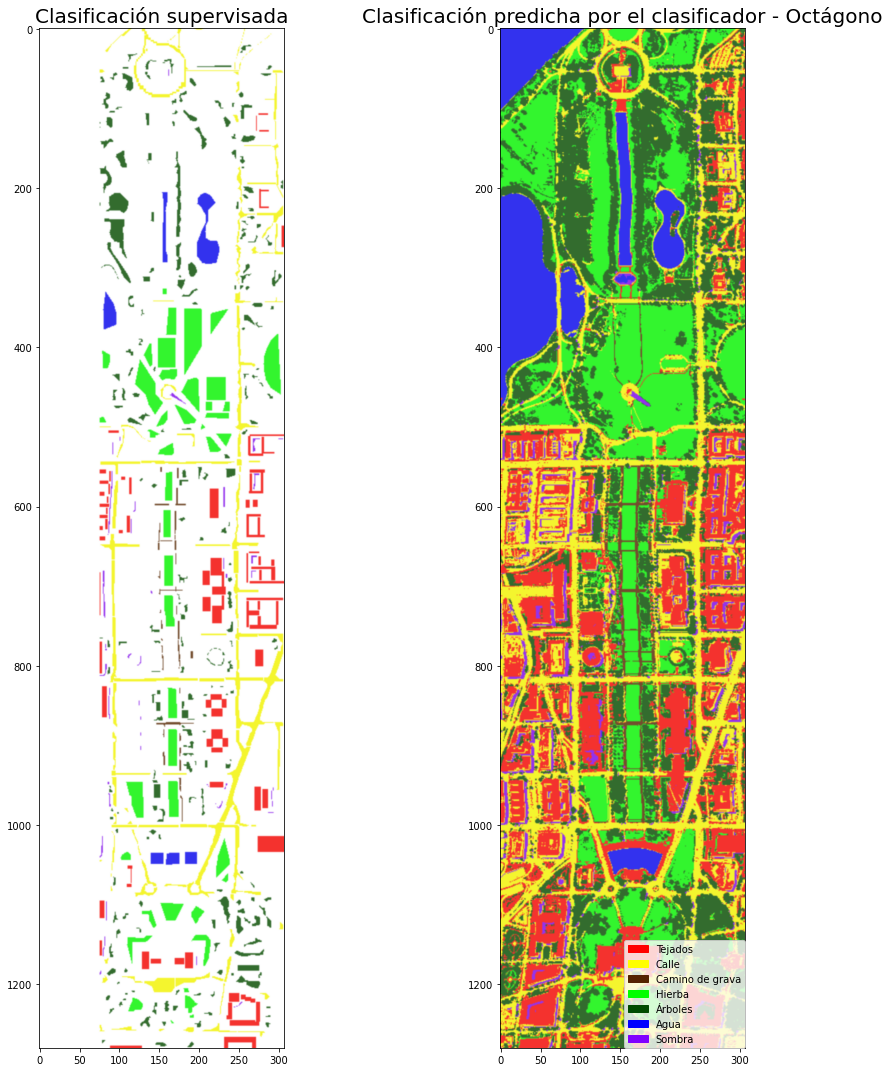

In [37]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(predict2,interpolation='bicubic')
plt.title("Clasificación predicha por el clasificador - Octágono", fontsize = 20)

creacionEMPWMall.mostrarLeyenda()

plt.tight_layout()
plt.show()

### Matriz de confusión utilizando el elemento estructural Rectángulo Vertical

Porcentaje de acierto: 98.89%
Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: Tejados
Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: Sombra


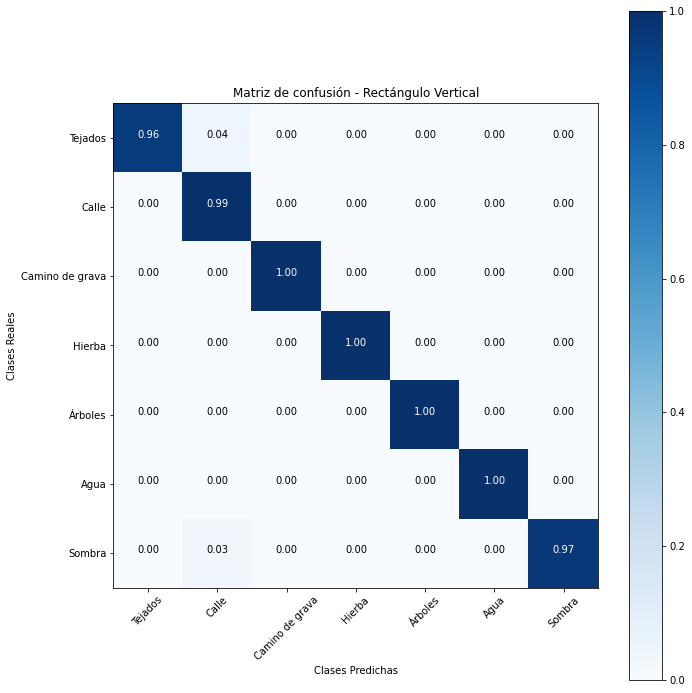

In [38]:
plt.figure(figsize=(10, 10))
creacionEMPWMall.prediccionVSReal(ypred3,ytest3,"Matriz de confusión - Rectángulo Vertical")
plt.show()

In [39]:
predict3 = creacionEMPWMall.imagenClasifPrediccion(emp_image3,clasifSVM3)

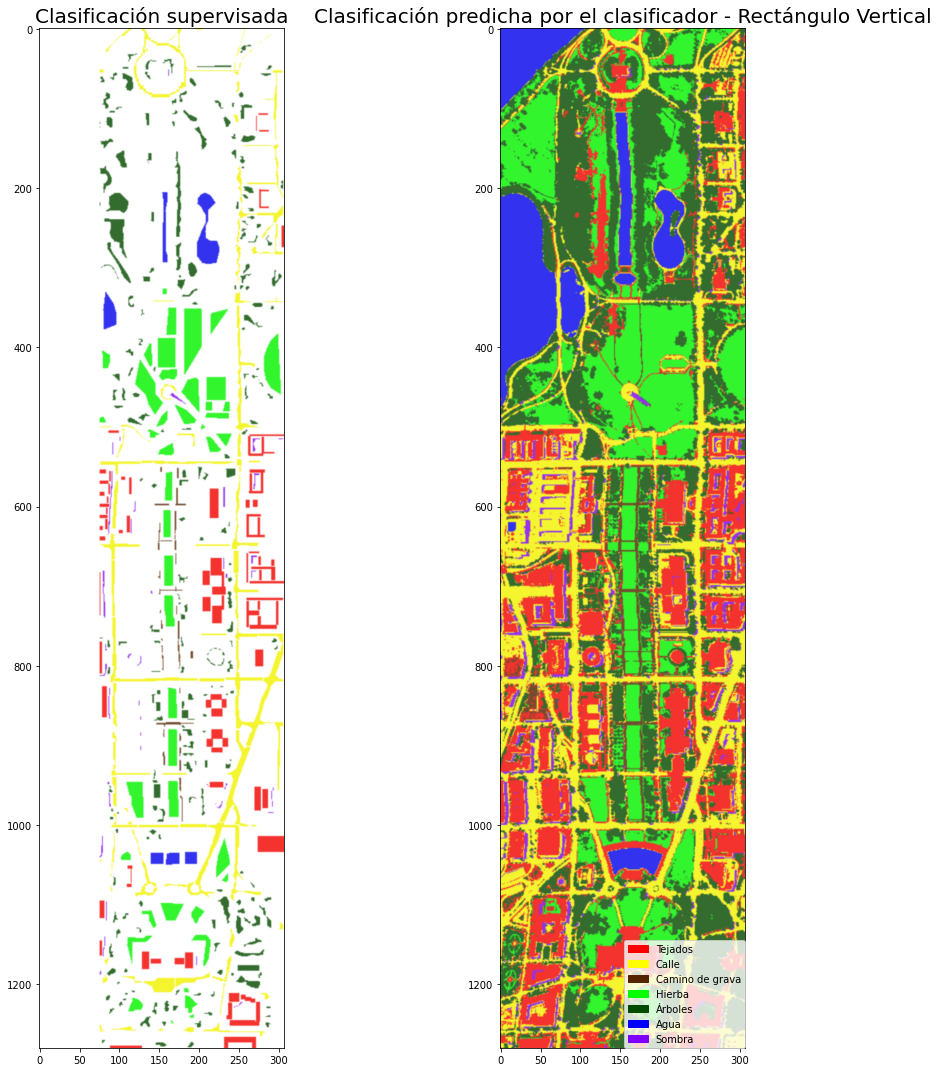

In [40]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(predict3,interpolation='bicubic')
plt.title("Clasificación predicha por el clasificador - Rectángulo Vertical", fontsize = 20)

creacionEMPWMall.mostrarLeyenda()


plt.tight_layout()
plt.show()

### Matriz de confusión utilizando el elemento estructural Rectángulo Horizontal

Porcentaje de acierto: 99.09%
Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: Tejados
Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: Sombra


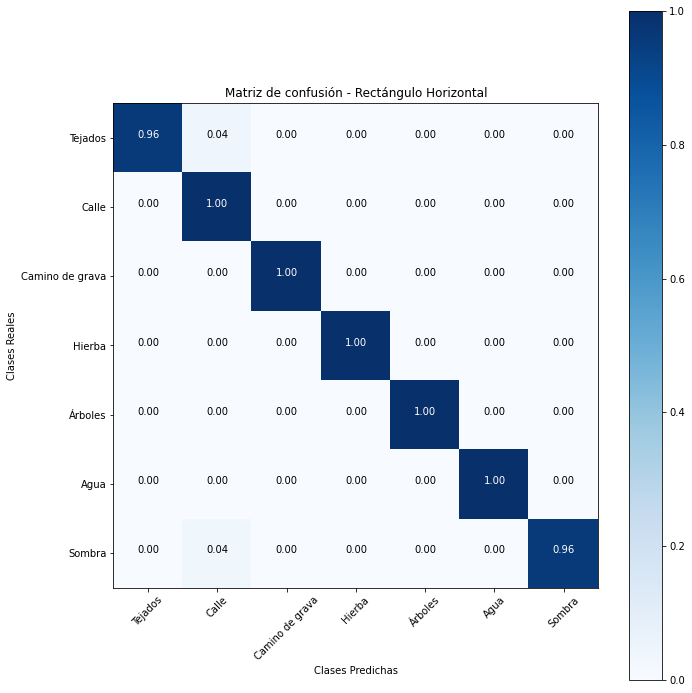

In [41]:
plt.figure(figsize=(10, 10))
creacionEMPWMall.prediccionVSReal(ypred4,ytest4,"Matriz de confusión - Rectángulo Horizontal")
plt.show()

In [42]:
predict4 = creacionEMPWMall.imagenClasifPrediccion(emp_image4,clasifSVM4)

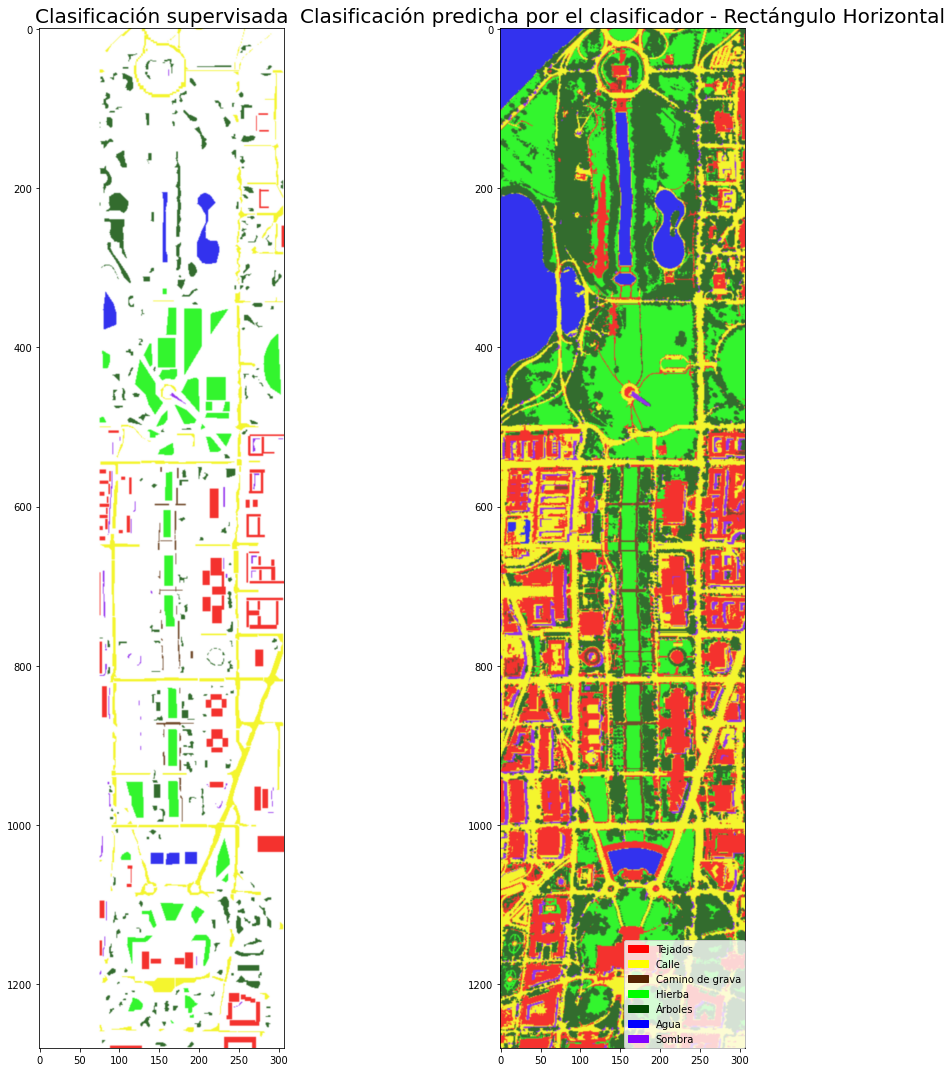

In [43]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(predict4,interpolation='bicubic')
plt.title("Clasificación predicha por el clasificador - Rectángulo Horizontal", fontsize = 20)

creacionEMPWMall.mostrarLeyenda()

plt.tight_layout()
plt.show()

### Matriz de confusión utilizando el dataset sin aplicar un EMP

Porcentaje de acierto: 97.01%
Clase con MENOR porcentaje de acierto, respecto al número de píxeles que REALMENTE son de esa clase: Sombra
Clase con MENOR porcentaje de acierto, respecto al número de píxeles PREDICHOS como de esa clase: Agua


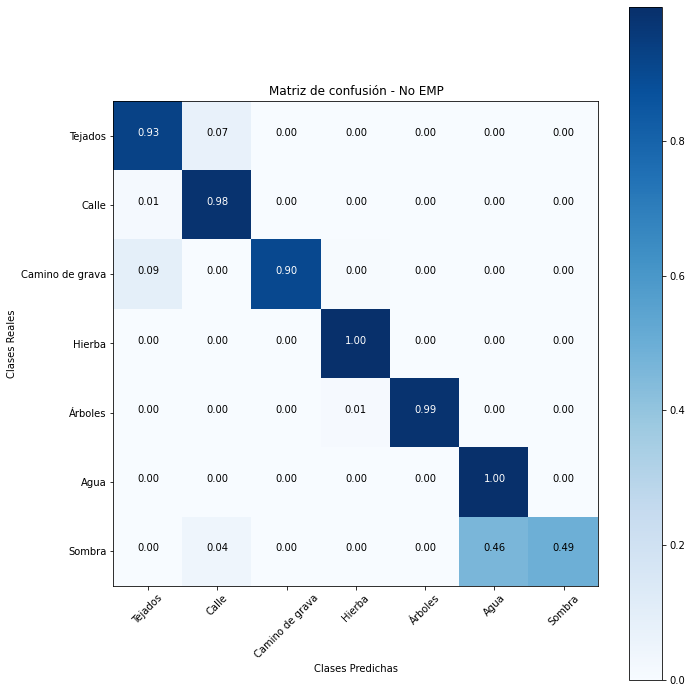

In [44]:
plt.figure(figsize=(10, 10))
creacionEMPWMall.prediccionVSReal(ypred5,ytest5,"Matriz de confusión - No EMP")
plt.show()

In [45]:
predict5 = creacionEMPWMall.imagenClasifPrediccion(pca_wmall,clasifSVM5)

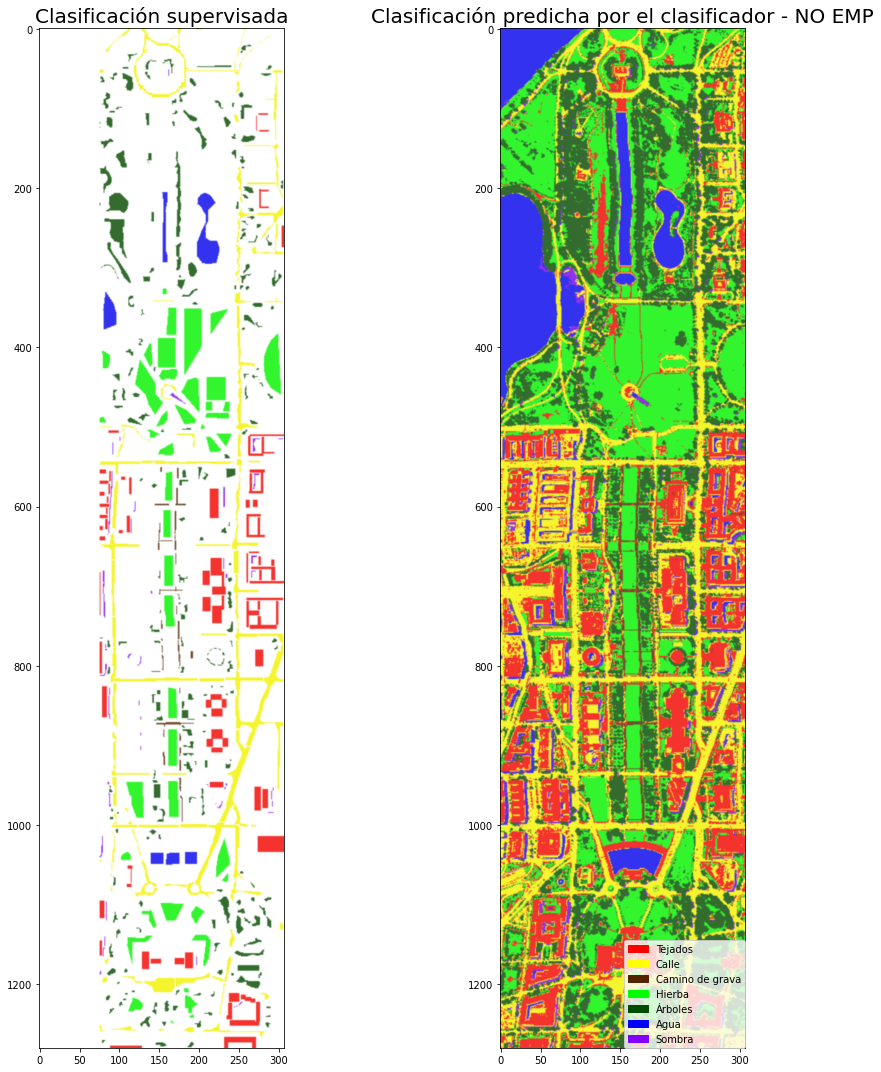

In [46]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(clasificador,interpolation='bicubic')
plt.title("Clasificación supervisada", fontsize = 20)

plt.subplot(1, 2, 2)
plt.imshow(predict5,interpolation='bicubic')
plt.title("Clasificación predicha por el clasificador - NO EMP", fontsize = 20)

creacionEMPWMall.mostrarLeyenda()


plt.tight_layout()
plt.show()

# Referencias:

#### Para más información sobre el tema considere leer los siguientes artículos:

 * [Web del dataset](https://engineering.purdue.edu/~biehl/MultiSpec/index.html)
 * [Repositorio GitHub con implementación de clasificación](https://github.com/andreybicalho/ExtendedMorphologicalProfiles)
 * [Estudio de clasificación usando EMP](https://www.researchgate.net/publication/224301504_Spectral_and_spatial_classification_of_hyperspectral_data_using_SVMs_and_morphological_profiles)
 * [Estudio de clasificación con ayuda de morfología](http://www.lsgi.polyu.edu.hk/academic_staff/John.Shi/publications/051-Morphological_profiles_based_on_differently_shaped_structuring_elements.pdf)
 * [Scikit-image](https://scikit-image.org/)
 * [Notas sobre Reconstrucción Morfológica](http://www.math.tau.ac.il/~turkel/notes/segmentation_morphology.pdf)
 * [Entendiendo la reconstrucción morfológica](https://es.mathworks.com/help/images/understanding-morphological-reconstruction.html?lang=en)







